In [1]:
import numpy as np
import matplotlib.pylab as plt
import math as math
from scipy.optimize import fmin
from iminuit import Minuit, describe, Struct
from scipy.spatial import distance
from scipy.sparse import vstack
import time
import seaborn as sns
%matplotlib  notebook

In [2]:
def nn(data0,data1,r=None,nneighbors=None):
    ret = -1
    ret_list=[]
    if r is not None and nneighbors is not None:
        exit(-1)
        return ret
    elif r is not None and nneighbors is None:
        rsq = r*r
        for d in data0.transpose():
            count=0
            diffx=d[0]-data1[0]
            diffy=d[1]-data1[1]
            diff= diffx*diffx + diffy*diffy
            count = len(diff[diff<rsq])
            ret_list.append(float(count)/(float(len(data1[0]))*r))
        ret_list = np.array(ret_list)
        return ret_list
    elif r is None and nneighbors is not None:
        for d in data0.transpose():
            diffx=d[0]-data1[0]
            diffy=d[1]-data1[1]
            diff= diffx*diffx + diffy*diffy
            diff.sort()
            radius2 = diff[nneighbors-1]
#            ret_list.append(1./np.sqrt(radius2))
            ret_list.append(float(nneighbors)/(np.pi*radius2)) # Let's do the inverse of the radius squared, since this is a 2D problem.
            #ret_list.append(float(nneighbors)/np.sqrt(radius2)) # 

        ret_list = np.array(ret_list)
        return ret_list
    return ret

In [19]:
def normal(x,mean,width):
    return (1.0/(width*np.sqrt(2*np.pi)))*(np.exp(-(x-mean)**2/(2*(width**2))))

# A product of two Gaussians
def signal_2D(npts,means,sigmas):
    pts = []
    for m,s in zip(means,sigmas):
        pts.append(np.random.normal(m,s,npts))
    pts = np.array(pts)
    return pts
    

# Flat in 2D
def background_2D(npts,lovals,hivals):
    pts = []
    for lo,hi in zip(lovals,hivals):
        width = hi-lo
        pts.append(lo + width*np.random.random(npts))
    pts = np.array(pts)
    return pts

# Helper function to generate signal and background at the same time
def gen_sig_and_bkg(npts,means,sigmas,lovals,hivals):
    sigpts = signal_2D(npts[0],means,sigmas)
    bkgpts = background_2D(npts[1],lovals,hivals)
    data = [sigpts[0].copy(),sigpts[1].copy()]
    data[0] = np.append(data[0],bkgpts[0])
    data[1] = np.append(data[1],bkgpts[1])
    data = np.array(data)
    return data

<IPython.core.display.Javascript object>


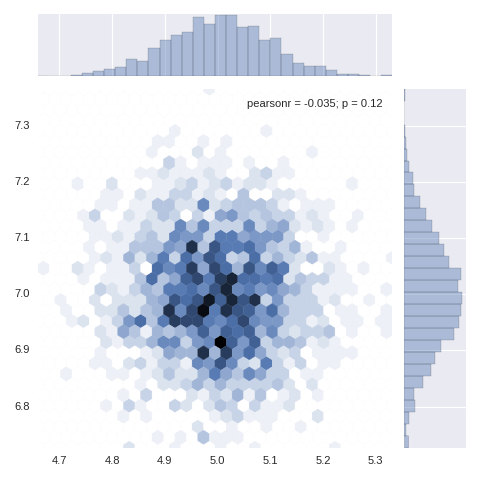

<IPython.core.display.Javascript object>


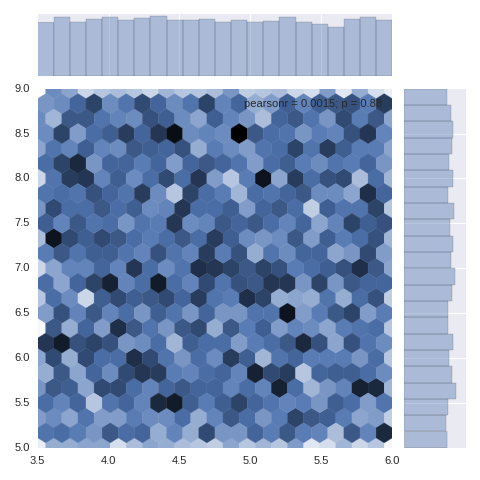

<IPython.core.display.Javascript object>


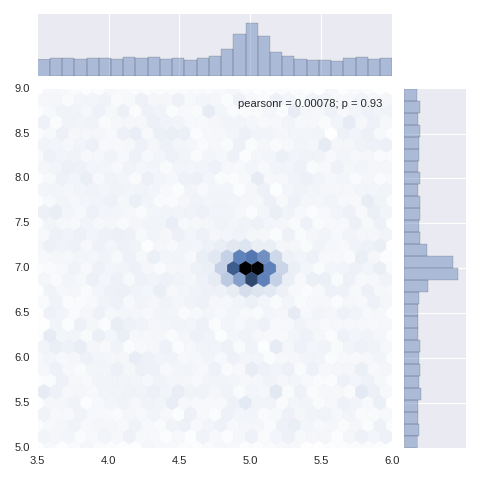

In [4]:
# Test the tools to generate the datasets.
sigpts = signal_2D(2000,[5.0,7.0],[0.1,0.1])
sns.jointplot(sigpts[0],sigpts[1],kind='hex')
bkgpts = background_2D(10000,[3.5,5],[6,9])
sns.jointplot(bkgpts[0],bkgpts[1],kind='hex')
data1 = [sigpts[0].copy(),sigpts[1].copy()]
data1[0] = np.append(data1[0],bkgpts[0])
data1[1] = np.append(data1[1],bkgpts[1])
data1 = np.array(data1)
sns.jointplot(data1[0],data1[1],kind='hex')

In [15]:
def bootstrapping(data,npts):
    for x in range(npts):
        bs_data_x=np.random.choice(data[0],npts)
        bs_data_y= np.random.choice(data[1],npts)
        bs_data= [bs_data_x.copy(),bs_data_y.copy()]
        
    return bs_data

In [35]:

nbkg = 1000
sigmeans = [5.0,7.0]
bkglos = [3.5,5]
bkghis = [6,9]
bootstrapping_iterations=2

def calc_pull(iterations, nsig, nMC, nneigh,cdist_bool,sigwidths):
    
    pull_frac_list=[]
    average_best_frac = 0
    frac = []
    fit_frac = []
    fit_frac_uncert = []
    frac_org = nsig/float(nsig+nbkg)

    for num in range(iterations):
        
        nsig_iteration = np.random.poisson(nsig)
        nbkg_iteration = np.random.poisson(nbkg)
        data = gen_sig_and_bkg([nsig_iteration,nbkg_iteration],sigmeans,sigwidths,bkglos,bkghis)
        signal_points= signal_2D(nMC,sigmeans,sigwidths)
        background_points = background_2D(nMC,bkglos,bkghis)
        frac_iteration = float(nsig_iteration)/(float(nbkg_iteration+nsig_iteration))
        frac.append(frac_iteration)
        
        if cdist_bool:
            signal_prob=nncdist(data,signal_points, nneighbors=nneigh)
            background_prob= nncdist(data,background_points, nneighbors=nneigh)
        else:
            signal_prob=nn(data,signal_points, nneighbors=nneigh)
            background_prob = nn(data,background_points, nneighbors=nneigh)
        
        signal_MC_bs = bootstrapping(signal_points, 10)
        background_MC_bs = bootstrapping(background_points, 10)
        signal_prob_bs=[]
        background_prob_bs=[]
        for x in range(bootstrapping_iterations):
            
            signal_prob_bs.append(nn(data,signal_MC_bs, nneighbors=nneigh))
            background_prob_bs.append( nn(data, background_MC_bs, nneighbors=nneigh))

        def tot_prob(frac):
            bs_prob=[]
            for x in range(bootstrapping_iterations):
                bs_prob.append(frac*signal_prob_bs[x] + ((1-frac)*background_prob_bs[x]))
            tot_prob=[]
            tot_prob.append(frac*signal_prob + ((1-frac)*background_prob))
            return np.array(tot_prob)
        
        def probability(frac):
            prob_sum=0
            prob=tot_prob(frac)
            for x in range(bootstrapping_iterations):
                x=tot_prob(frac)
                prob_sum+=-np.log(x[x>0]).sum()
            return -np.log(prob[prob>0]).sum()+prob_sum
        
        m1=Minuit(probability,frac= 0.2,limit_frac=(0.001,1),error_frac=0.001,errordef = 0.5,print_level=0)
        m1.migrad()

        if (m1.get_fmin().is_valid):
            param=m1.values
            err=m1.errors
            fit_frac.append(param["frac"])
            fit_frac_uncert.append(err["frac"])
            pull_frac=(frac_org-param["frac"])/err["frac"]
            pull_frac_list.append(pull_frac)
            
    return pull_frac_list, frac, fit_frac, fit_frac_uncert,iterations

In [36]:

means1=[]
stds1=[]

sig_list=[200]
MC_list=[1000]
#rad_list=[0.1]
#width_list=[0.06,.15]
width_list=[0.1]
n=[5]

niterations = 10


pulls_list ={}
for sig in sig_list:
    for MC in MC_list: #,100000]:
        start = time.time()
        for nneighbors in n:#,0.05,0.1,0.15,0.20]: #, 0.10,0.20,0.50]:
            for w in width_list:
                sig_widths=[w,w]
                start = time.time()
                print 'number of signal points: %s \t number of MC point: %s \t radius: %s \t width: %s' % (sig,MC,nneighbors,w)
                pulls,org_vals1,fit_vals1,fit_uncerts1,iteration= calc_pull(niterations, sig, MC, nneighbors,False,sig_widths)
                name='MC' +str(MC) + 'nneighbors'+str(nneighbors)
                pulls_list[name]=pulls

                parameters_mean = {'signal': sig, 'MC_points': MC, 'nearest neighbors': nneighbors, 'mean pulls': np.mean(pulls), 'width':w}
                means1.append(parameters_mean)
                parameters_std = {'signal': sig, 'MC_points': MC, 'nearest neighbors': nneighbors, 'mean stds': np.std(pulls),'width':w}
                stds1.append(parameters_std)
                print "time to calc %d iterations: %f s" % (niterations, time.time() - start)        

print means1
print stds1
print '--------------------'



number of signal points: 200 	 number of MC point: 1000 	 radius: 5 	 width: 0.1
time to calc 10 iterations: 1.162508 s
[{'width': 0.1, 'signal': 200, 'mean pulls': -0.89480674376448766, 'nearest neighbors': 5, 'MC_points': 1000}]
[{'width': 0.1, 'signal': 200, 'mean stds': 1.1430942186218771, 'nearest neighbors': 5, 'MC_points': 1000}]
--------------------


In [ ]:
print (np.array(fit_vals1)-np.array(org_vals1))/np.array(fit_uncerts1)

print fit_uncerts1

In [ ]:
plt.figure()
plt.hist(pulls,bins=20)

In [ ]:
plt.figure()
colors=['b','g','y','r']
markers=['o','^','+']
marker_sizes=[5,10,60]
labels=[]


for item in means1:
    if item['width']==width_list[0]:
        label='MC=' + str(item['MC_points']) + ' signal=' + str(item['signal'])
        
    
        if item['MC_points']== MC_list[0]:
            color=colors[0]
        #if item['MC_points']==MC_list[1]:
        #    color=colors[1]

        if item['signal']==sig_list[0]:
            marker=markers[0]
        #if item['signal']==sig_list[1]:
        #    marker=markers[1]
        for x in labels:
            if label==x:
                label=""       
        plt.plot(item['nearest neighbors'],item['mean pulls'], color=color, marker=marker,label=label)
        labels.append(label)

plt.legend(loc='lower right')
plt.title("Means with widths of "+str(width_list[0]))
           
plt.figure()
labels=[]
           
for item in means1:
    if item['width']==width_list[1]:
        label='MC=' + str(item['MC_points']) +  ' signal=' + str(item['signal'])
    
        if item['MC_points']== MC_list[0]:
            color=colors[0]
        #if item['MC_points']==MC_list[1]:
        #    color=colors[1]

        if item['signal']==sig_list[0]:
            marker=markers[0]
        #if item['signal']==sig_list[1]:
        #    marker=markers[1]

        for x in labels:
            if label==x:
                label=""
            
        plt.plot(item['nearest neighbors'],item['mean pulls'], color=color, marker=marker,label=label)
        labels.append(label)

plt.legend(loc='lower right')    

plt.title("Means with widths of "+str(width_list[1]))


plt.figure()
labels=[]
           
for item in stds1:
    if item['width']==width_list[0]:
        label='MC=' + str(item['MC_points']) +  ' signal=' + str(item['signal'])
    
        if item['MC_points']== MC_list[0]:
            color=colors[0]
        #if item['MC_points']==MC_list[1]:
        #    color=colors[1]

        if item['signal']==sig_list[0]:
            marker=markers[0]
        #if item['signal']==sig_list[1]:
        #    marker=markers[1]

        for x in labels:
            if label==x:
                label=""
            
        plt.plot(item['nearest neighbors'],item['mean stds'], color=color, marker=marker,label=label)
        labels.append(label)

plt.legend(loc='lower right')   

plt.title("Standard Deviations with widths of "+str(width_list[0]))




plt.figure()
labels=[]
           
for item in stds1:
    if item['width']==width_list[1]:
        label='MC=' + str(item['MC_points']) +  ' signal=' + str(item['signal'])
    
        if item['MC_points']== MC_list[0]:
            color=colors[0]
        #if item['MC_points']==MC_list[1]:
        #    color=colors[1]

        if item['signal']==sig_list[0]:
            marker=markers[0]
        #if item['signal']==sig_list[1]:
        #    marker=markers[1]

        for x in labels:
            if label==x:
                label=""
            
        plt.plot(item['nearest neighbors'],item['mean stds'], color=color, marker=marker,label=label)
        labels.append(label)

plt.legend(loc='lower right')

plt.title("Standard Deviations with widths of "+str(width_list[1]))



In [ ]:
#800 signal points
#pythagorean method
means800=[]
stds800=[]

#sig_widths = [0.6,0.6]
sig_list=[200,400]
MC_list=[10000,100000]
rad_list=[0.01,0.05,0.1,0.15,0.20]
width_list=[0.06,.15]

pulls_list ={}
for sig in sig_list:
    for MC in MC_list: #,100000]:
        start = time.time()
        for rad in rad_list:#,0.05,0.1,0.15,0.20]: #, 0.10,0.20,0.50]:
            for w in width_list:
                sign_widths=[w,w]
                start = time.time()
                print 'number of signal points: %s \t number of MC point: %s \tradius: %s \t width: %s' % (sig,MC,rad,w)
                pulls,org_vals1,fit_vals1,fit_uncerts1,iteration= calc_pull(10, sig, MC, rad,False,sig_widths)
                name='MC' +str(MC) + 'rad'+str(rad)
                pulls_list[name]=pulls

                parameters_mean = {'signal': sig, 'MC_points': MC, 'radius': rad, 'mean pulls': np.mean(pulls), 'width':w}
                means800.append(parameters_mean)
                parameters_std = {'signal': sig, 'MC_points': MC, 'radius': rad, 'mean stds': np.std(pulls),'width':w}
                stds800.append(parameters_std)
                print "time to calc 10 iterations: %f s" % (time.time() - start)        

print means800
print stds800
print '--------------------'



In [ ]:
plt.figure()
colors=['b','g','y','r']
markers=['o','^','+']
marker_sizes=[5,10,60]
labels=[]

for item in means800:
    label='MC=' + str(item['MC_points']) + ' width='+str(item['width'])+ ' signal=' + str(item['signal'])
    if item['MC_points']== MC_list[0]:
        color=colors[0]
    if item['MC_points']==MC_list[1]:
        color=colors[1]
        
    if item['signal']==sig_list[0]:
        marker=markers[0]
    if item['signal']==sig_list[1]:
        marker=markers[1]
        
    if item['width']==width_list[0]:
        marker_size=marker_sizes[0]
    if item['width']==width_list[1]:
        marker_size=marker_sizes[1]
        
    for x in labels:
        if label==x:
            label=""
            
    plt.plot(item['radius'],item['mean pulls'], color=color, marker=marker,markersize=marker_size,label=label)
    labels.append(label)

plt.legend(loc='center left', bbox_to_anchor=(0.6,0.5))
#plt.ylim(-1,.1)
#plt.ylim(-.5,.5)
labels=[]

plt.figure()
for item in stds800:
    label='MC=' + str(item['MC_points']) + ' width='+str(item['width'])+ ' signal=' + str(item['signal'])
    if item['MC_points']== MC_list[0]:
        color=colors[0]
    if item['MC_points']==MC_list[1]:
        color=colors[1]
    if item['signal']==sig_list[0]:
        marker=markers[0]
    if item['signal']==sig_list[1]:
        marker=markers[1]
    if item['width']==width_list[0]:
        marker_size=marker_sizes[0]
    if item['width']==width_list[1]:
        marker_size=marker_sizes[1]
    for x in labels:
        if label==x:
            label=""
            
    plt.plot(item['radius'],item['mean stds'], color=color, marker=marker,markersize=marker_size,label=label)
labels.append(label)

plt.legend(loc='center left', bbox_to_anchor=(0.6,0.5))
#plt.xlim(0,.15)